# Demo for CLEAR: Calibrated Learning for Epistemic and Aleatoric Risk



This notebook-style script demonstrates the CLEAR pipeline for generating prediction intervals.

It covers three main scenarios, in the following order:

1.  Training a PCS ensemble on synthetic data.

2.  Using pre-trained PCS ensemble results for the Parkinsons dataset.

3.  Retraining a PCS ensemble on a real-world dataset (Airfoil).



Comparisons are made against PCS and "CQR-R+" which is just `ALEATORIC-R` from our paper (CQR with bootstrapping, trained on residuals). Note that you can either run `demo.py` or `demo.ipynb` as the content are the same. 

In [22]:
# -------------------
# COLAB CONFIGURATION
# -------------------
##################################################################################
# Instructions for google colab without using conda (uncomment in case of colab) #
##################################################################################
## Step 1: Install the packages, without a need to specify their versions, however, 
## please note that the results may slightly differ compared to the experiments,
## since we use a different version of `numpy` and `scipy` and several cores in parallel.
#!pip install scipy numpy joblib matplotlib pandas plotly pygam quantile_forest scikit_learn scikit_lego seaborn setuptools torch tqdm ucimlrepo xgboost pytest openml tcl matplotlib-inline celer

## Step 2 (Optional): In case you're uploading the zip file to the colab, you can unzip it
## Clone from https://github.com/Unco3892/clear and unzip the folder
#!git clone https://github.com/Unco3892/clear.git
#!unzip clear.zip

## Step 3: Run the tests
#!pytest

## Step 4: Restart the runtime of google colab and run the chunk again with the code below commented out
# import os
# os.kill(os.getpid(), 9)


In [23]:
# ----------------------------------
# CLEAR-PCS-ALEATORIC CONFIGURATION
# ----------------------------------
import numpy as np
import os

# General settings
# Note: Note the the bootstrapps were reduced from 100 to 10 for runtime (compared to the paper experiments). On google colab (only 2 cores in the free version), setting it to 100 can be too long.
DESIRED_COVERAGE = 0.95       # Target coverage for prediction intervals
N_BOOTSTRAPS_CLEAR = 10       # Number of bootstrap samples for CLEAR's internal calibration
N_BOOTSTRAPS_PCS = 10         # Number of bootstrap samples for PCS training
N_JOBS = -1                   # Number of parallel jobs (aligned with benchmark_real_data.py default)
RANDOM_STATE = 777            # Random seed for reproducibility
LAMBDAS_CLEAR = np.concatenate((np.linspace(0, 0.09, 10), np.logspace(-1, 2, 4001))) # Lambda grid for CLEAR

# Case 1: Parkinsons dataset (pre-trained)
PARKINSONS_PCS_FILE_DIR = os.path.join("models", "demo")
PARKINSONS_DATASET_NAME = "parkinsons"

# Case 2: Airfoil dataset (re-train)
AIRFOIL_DATASET_NAME = "airfoil"
AIRFOIL_BASE_MODEL_PCS = "qrf" # 'qrf' or 'qxgb' for PCS training

# Case 3: Synthetic data
SYNTHETIC_N_TRAIN_CALIB = 2000
SYNTHETIC_N_TEST = 1000
SYNTHETIC_N_FEATURES = 5
SYNTHETIC_BASE_MODEL_PCS = "qrf"

# Aleatoric model for CLEAR and CQR-R+ (can be 'rf', 'qxgb')
SYNTHETIC_ALEATORIC_MODEL_CLEAR = ['rf']
PARKINSONS_ALEATORIC_MODEL_CLEAR = ['rf']
AIRFOIL_ALEATORIC_MODEL_CLEAR = ['rf']

# Ensure random seed is set for numpy
np.random.seed(RANDOM_STATE)

print("Configuration settings loaded.")


Configuration settings loaded.


## Imports and Path Setup



This cell handles necessary imports and dynamically adjusts `sys.path` to help locate project-specific modules. The `src` directory is added to the path to allow direct imports like `from clear.clear import CLEAR`.

In [24]:
# --------------------------
# IMPORTS & PATH SETUP
# --------------------------
import sys 
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from quantile_forest import RandomForestQuantileRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# --- Python Path Setup ---
# PROJECT_ROOT = os.path.dirname(os.path.abspath(__file__))
# Set project root as current path without using __file__
# PROJECT_ROOT = os.path.dirname(os.path.abspath(sys.argv[0]))

# Determine PROJECT_ROOT in a way that works for both scripts and notebooks
try:
    # If run as a script, __file__ is defined
    PROJECT_ROOT = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If run in a notebook or interactive interpreter, __file__ is not defined
    # Assume the notebook/current working directory is the project root
    PROJECT_ROOT = os.path.abspath(os.getcwd())

# Add PROJECT_ROOT/src to sys.path for imports like 'from clear.clear import ...'
# This also allows modules within 'src' (like clear.py) to find their own submodules (like clear.utils)
# because 'clear' will be treated as a top-level package within SRC_DIR.
SRC_DIR = os.path.join(PROJECT_ROOT, 'src')
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
# CLEAR imports
from src.clear.clear import CLEAR
from src.clear.metrics import evaluate_intervals
from src.clear.utils import plot_prediction_intervals

# Add PROJECT_ROOT/PCS_UQ/src for PCS imports
PCS_UQ_SRC_DIR = os.path.abspath(os.path.join(PROJECT_ROOT, 'PCS_UQ', 'src'))
if PCS_UQ_SRC_DIR not in sys.path:
    sys.path.insert(0, PCS_UQ_SRC_DIR)
# --- End Path Setup ---
# PCS UQ imports
from PCS.regression.pcs_uq import PCS_UQ

print("All imports and path setups attempted.")


All imports and path setups attempted.


## Helper Functions



This section defines helper functions for:

1.  Reconstructing pandas DataFrames from a serialized dictionary format, often used when loading pickled data.

2.  Safely flattening various array-like objects (lists, pandas Series, numpy arrays) into 1D numpy arrays.

3.  Generating synthetic regression data with controllable features and heteroscedastic noise, based on a non-linear function of input features.

4.  Training a simplified PCS (Predictability, Computability, Stability) ensemble by bootstrapping a chosen base model (e.g., Quantile Random Forest or Quantile XGBoost) to produce raw and calibrated prediction intervals.

5.  Computing CQR-R+ (Conformalized Quantile Regression - Residuals) prediction intervals, where intervals are centered on PCS median predictions and widths are derived from an aleatoric model trained on PCS residuals, then conformally calibrated.

In [25]:

def reconstruct_dataframe(df_object):
    """
    Reconstructs a pandas DataFrame from a dictionary if it was serialized.

    This is useful when loading data from pickles where DataFrames might have been
    stored as dictionaries.

    Args:
        df_object (dict or pd.DataFrame): The object to reconstruct. If it's a
                                          dictionary matching the expected serialized
                                          format, it's converted to a DataFrame.
                                          Otherwise, it's returned as is.

    Returns:
        pd.DataFrame or any: The reconstructed DataFrame or the original object.
    """
    if isinstance(df_object, dict) and df_object.get("_pandas_dataframe_", False):
        # Assuming pandas (pd) is imported in the global scope of demo.py
        return pd.DataFrame(
            data=df_object["data"],
            columns=df_object["columns"],
            index=df_object["index"]
        )
    return df_object

def safe_flatten(arr):
    """
    Safely flattens an array-like object to a 1D numpy array.

    If the object has a `flatten` method (like numpy arrays or pandas Series),
    it's used. Otherwise, the object is converted to a numpy array and then flattened.

    Args:
        arr (array-like): The object to flatten (e.g., list, pandas Series, numpy array).

    Returns:
        np.ndarray: A 1D numpy array.
    """
    if hasattr(arr, 'flatten'):
        return arr.flatten()
    else:
        # Assuming numpy (np) is imported in the global scope of demo.py
        return np.array(arr).flatten()

def generate_synthetic_data(n_samples, n_features, random_state=RANDOM_STATE):
    """
    Generates synthetic data for regression tasks with heteroscedastic noise.

    The data generation process involves creating features X from a uniform distribution.
    The target variable y is generated based on a non-linear function of X
    with added Gaussian noise, where the standard deviation of the noise
    is also a function of X (heteroscedastic).

    Args:
        n_samples (int): The total number of samples to generate.
        n_features (int): The number of features for each sample.
        random_state (int, optional): Seed for reproducibility. Defaults to RANDOM_STATE.

    Returns:
        tuple:
            - pd.DataFrame: Feature matrix X with shape (n_samples, n_features).
            - pd.Series: Target vector y with shape (n_samples,).
    """
    np.random.seed(random_state)
    X = np.random.rand(n_samples, n_features) * 10 - 5
    
    def cond_exp_synthetic(x_in):
        term1 = 2 * x_in[:, 0]
        term2 = np.sin(x_in[:, 1]) if x_in.shape[1] > 1 else np.sin(x_in[:, 0]) # Handle single feature case
        term3 = 0.5 * x_in[:, 2]**2 if x_in.shape[1] >= 3 else 0
        return term1 + term2 + term3
        
    def noise_sd_fn_synthetic(x_in):
        term1_noise = 0.3 * np.abs(x_in[:, 0])
        term2_noise = 0.2 * (x_in[:, 1] > 0 if x_in.shape[1] > 1 else 0) # Handle single feature
        return 0.5 + term1_noise + term2_noise

    y_mean = cond_exp_synthetic(X)
    noise_sd = noise_sd_fn_synthetic(X)
    y = y_mean + np.random.normal(0, noise_sd, n_samples)
    
    return pd.DataFrame(X, columns=[f'feat_{i}' for i in range(n_features)]), pd.Series(y, name='target')


def train_pcs_ensemble(X_train, y_train, X_val, y_val, X_test,
                       coverage, base_model_type='qxgb', n_bootstrap_pcs=N_BOOTSTRAPS_PCS, random_state=RANDOM_STATE):
    """
    Trains a simplified PCS (Predictability, Computability, Stability) ensemble.

    This function simulates a PCS ensemble by training multiple instances of a single
    base model type (e.g., 'qrf' for RandomForestQuantileRegressor or 'qxgb' for XGBRegressor)
    on bootstrap samples of the training data. It then uses these models to generate
    raw (uncalibrated) prediction intervals and a calibrated interval on the test set
    using a validation set for PCS's internal calibration.

    Args:
        X_train (pd.DataFrame or np.ndarray): Training features.
        y_train (pd.Series or np.ndarray): Training target values.
        X_val (pd.DataFrame or np.ndarray): Validation features for PCS calibration.
        y_val (pd.Series or np.ndarray): Validation target values for PCS calibration.
        X_test (pd.DataFrame or np.ndarray): Test features.
        coverage (float): The desired coverage level for PCS intervals (e.g., 0.95).
        base_model_type (str, optional): Type of base model for PCS.
                                         Supported: 'qrf' (RandomForestQuantileRegressor),
                                         'qxgb' (XGBRegressor). Defaults to 'qxgb'.
        n_bootstrap_pcs (int, optional): Number of bootstrap samples for PCS.
                                         Defaults to N_BOOTSTRAPS_PCS.
        random_state (int, optional): Seed for reproducibility. Defaults to RANDOM_STATE.

    Returns:
        dict: A dictionary containing raw PCS predictions (lower, median, upper) for
              train, validation, and test sets, calibrated PCS predictions (lower, upper)
              for the test set, and the PCS calibration factor 'gamma'.
    """
    print(f"Training PCS ensemble with base model: {base_model_type}...")
    alpha_pcs = 1 - coverage

    if base_model_type == 'qrf':
        models = {'QRF': RandomForestQuantileRegressor(n_estimators=100, random_state=random_state, min_samples_leaf=10, default_quantiles=0.5)}
    elif base_model_type == 'qxgb':
        models = {'QXGB': XGBRegressor(n_estimators=100, random_state=random_state, n_jobs=N_JOBS, min_child_weight=10, objective='reg:quantileerror', quantiles=0.5)}
    else:
        raise ValueError(f"Unsupported base_model_type for PCS. Choose 'qrf' or 'qxgb'. Got: {base_model_type}")

    if PCS_UQ.__name__ == 'PCS_UQ_dummy':
        print("Skipping PCS training as PCS_UQ module was not found (using dummy).")
        dummy_len_test = len(X_test) if X_test is not None else 0
        dummy_len_train = len(X_train) if X_train is not None else 0
        dummy_len_val = len(X_val) if X_val is not None else 0
        return {
            'train_raw_lower': np.zeros(dummy_len_train), 'train_raw_median': np.zeros(dummy_len_train), 'train_raw_upper': np.zeros(dummy_len_train),
            'val_raw_lower': np.zeros(dummy_len_val), 'val_raw_median': np.zeros(dummy_len_val), 'val_raw_upper': np.zeros(dummy_len_val),
            'test_raw_lower': np.zeros(dummy_len_test), 'test_raw_median': np.zeros(dummy_len_test), 'test_raw_upper': np.zeros(dummy_len_test),
            'test_calib_lower': np.zeros(dummy_len_test), 'test_calib_upper': np.zeros(dummy_len_test),
            'gamma': 1.0
        }

    pcs_model = PCS_UQ(
        models=models,
        num_bootstraps=n_bootstrap_pcs,
        alpha=alpha_pcs, 
        seed=random_state,
        top_k=1, 
        calibration_method='multiplicative'
    )

    X_train_np, y_train_np = np.array(X_train), safe_flatten(y_train)
    X_val_np, y_val_np = np.array(X_val), safe_flatten(y_val)
    X_test_np = np.array(X_test)

    pcs_model.fit(X=X_train_np, y=y_train_np, X_calib=X_val_np, y_calib=y_val_np)
    print(f"PCS calibration complete. Gamma: {getattr(pcs_model, 'gamma', 'N/A'):.4f}")

    raw_train_preds = pcs_model.get_intervals(X_train_np) # [lower, median, upper]
    raw_val_preds = pcs_model.get_intervals(X_val_np)     # [lower, median, upper]
    raw_test_preds = pcs_model.get_intervals(X_test_np)    # [lower, median, upper]
    calibrated_test_preds = pcs_model.predict(X_test_np)   # [lower, upper]

    pcs_results = {
        'train_raw_lower': raw_train_preds[:, 0], 'train_raw_median': raw_train_preds[:, 1], 'train_raw_upper': raw_train_preds[:, 2],
        'val_raw_lower': raw_val_preds[:, 0], 'val_raw_median': raw_val_preds[:, 1], 'val_raw_upper': raw_val_preds[:, 2],
        'test_raw_lower': raw_test_preds[:, 0], 'test_raw_median': raw_test_preds[:, 1], 'test_raw_upper': raw_test_preds[:, 2],
        'test_calib_lower': calibrated_test_preds[:, 0], 'test_calib_upper': calibrated_test_preds[:, 1],
        'gamma': getattr(pcs_model, 'gamma', 1.0) # Default if gamma not present
    }
    return pcs_results

def compute_cqr_r_plus_intervals(y_calib,
                                 aleatoric_median_calib, aleatoric_lower_calib, aleatoric_upper_calib,
                                 pcs_median_calib,
                                 pcs_median_test,
                                 aleatoric_median_test, aleatoric_lower_test, aleatoric_upper_test,
                                 coverage):
    """
    Computes CQR-R+ prediction intervals.

    CQR-R+ is a variant of Conformalized Quantile Regression (CQR) where we
    the prediction interval is centered around the PCS (epistemic) median.
    The width of the interval is determined by an aleatoric uncertainty model
    (trained on residuals of the PCS median) and then conformally calibrated.

    Args:
        y_calib (pd.Series or np.ndarray): True target values for the calibration set.
        aleatoric_median_calib (np.ndarray): Median predictions from the aleatoric model on calibration set.
        aleatoric_lower_calib (np.ndarray): Lower quantile predictions from aleatoric model on calibration set.
        aleatoric_upper_calib (np.ndarray): Upper quantile predictions from aleatoric model on calibration set.
        pcs_median_calib (np.ndarray): Median predictions from PCS model on calibration set.
        pcs_median_test (np.ndarray): Median predictions from PCS model on test set.
        aleatoric_median_test (np.ndarray): Median predictions from aleatoric model on test set.
        aleatoric_lower_test (np.ndarray): Lower quantile predictions from aleatoric model on test set.
        aleatoric_upper_test (np.ndarray): Upper quantile predictions from aleatoric model on test set.
        coverage (float): The desired coverage level for the CQR-R+ intervals.

    Returns:
        tuple:
            - np.ndarray: Lower bounds of the CQR-R+ prediction intervals for the test set.
            - np.ndarray: Median predictions (PCS median) for the test set.
            - np.ndarray: Upper bounds of the CQR-R+ prediction intervals for the test set.
    """
    print("Computing CQR-R+ intervals...")
    y_calib_np = safe_flatten(y_calib)
    pcs_median_calib_np = safe_flatten(pcs_median_calib)
    aleatoric_median_calib_np = safe_flatten(aleatoric_median_calib)
    aleatoric_lower_calib_np = safe_flatten(aleatoric_lower_calib)
    aleatoric_upper_calib_np = safe_flatten(aleatoric_upper_calib)

    calib_lower_centered_on_pcs = pcs_median_calib_np - (aleatoric_median_calib_np - aleatoric_lower_calib_np)
    calib_upper_centered_on_pcs = pcs_median_calib_np + (aleatoric_upper_calib_np - aleatoric_median_calib_np)
    
    scores = np.maximum(calib_lower_centered_on_pcs - y_calib_np, y_calib_np - calib_upper_centered_on_pcs)
    
    n_calib = len(y_calib_np)
    alpha_conf = 1 - coverage
    q_level = min((1 - alpha_conf) * (1 + 1 / n_calib), 1.0)
    adjustment = np.quantile(scores, q_level, method='higher')
    print(f"CQR-R+ adjustment: {adjustment:.4f}")
    
    pcs_median_test_np = safe_flatten(pcs_median_test)
    aleatoric_median_test_np = safe_flatten(aleatoric_median_test)
    aleatoric_lower_test_np = safe_flatten(aleatoric_lower_test)
    aleatoric_upper_test_np = safe_flatten(aleatoric_upper_test)

    test_lower_centered_on_pcs = pcs_median_test_np - (aleatoric_median_test_np - aleatoric_lower_test_np)
    test_upper_centered_on_pcs = pcs_median_test_np + (aleatoric_upper_test_np - aleatoric_median_test_np)
    
    cqr_r_plus_lower = test_lower_centered_on_pcs - adjustment
    cqr_r_plus_upper = test_upper_centered_on_pcs + adjustment
    
    return cqr_r_plus_lower, pcs_median_test_np, cqr_r_plus_upper # Return PCS median as the center

print("Helper functions defined.")


Helper functions defined.


## Case 1: Training PCS on Synthetic Data



In the first case, we generate synthetic data, train a PCS ensemble, and apply CLEAR. The underlying data generating process and noise characteristics are known.

In [26]:
print("--- Case 1: Synthetic Data (Train PCS from scratch) ---")
X_synth, y_synth = generate_synthetic_data(SYNTHETIC_N_TRAIN_CALIB + SYNTHETIC_N_TEST, SYNTHETIC_N_FEATURES)
X_train_val_s, X_test_s, y_train_val_s, y_test_s = train_test_split(
    X_synth, y_synth, test_size=SYNTHETIC_N_TEST, random_state=RANDOM_STATE
)
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(
    X_train_val_s, y_train_val_s, test_size=0.5, random_state=RANDOM_STATE
)
print(f"Synthetic data shapes: Train ({X_train_s.shape}), Valid ({X_valid_s.shape}), Test ({X_test_s.shape})")


--- Case 1: Synthetic Data (Train PCS from scratch) ---
Synthetic data shapes: Train ((1000, 5)), Valid ((1000, 5)), Test ((1000, 5))


### Train Epistemic Model (PCS) and Run CLEAR for Case 1 (Synthetic Data)



Here, we train the PCS ensemble, then fit the aleatoric component of CLEAR (optionally on residuals of the PCS median), calibrate CLEAR, and compute intervals. We also compute intervals for CQR-R+ and the PCS baseline.

In [27]:
pcs_results_s = train_pcs_ensemble(X_train_s, y_train_s, X_valid_s, y_valid_s, X_test_s, DESIRED_COVERAGE, base_model_type=SYNTHETIC_BASE_MODEL_PCS)
print("Running CLEAR (Residual) for Synthetic data...")
clear_model_s_res = CLEAR(
    desired_coverage=DESIRED_COVERAGE, 
    lambdas=LAMBDAS_CLEAR, 
    n_bootstraps=N_BOOTSTRAPS_CLEAR, 
    random_state=RANDOM_STATE, 
    n_jobs=N_JOBS
)
clear_model_s_res.fit_aleatoric(X_train_s, y_train_s, 
                                quantile_model=SYNTHETIC_ALEATORIC_MODEL_CLEAR,
                                fit_on_residuals=True, 
                                epistemic_preds=pcs_results_s['train_raw_median'])
aleatoric_val_s_res = clear_model_s_res.predict_aleatoric(X_valid_s, epistemic_preds=pcs_results_s['val_raw_median'])
aleatoric_test_s_res = clear_model_s_res.predict_aleatoric(X_test_s, epistemic_preds=pcs_results_s['test_raw_median'])
clear_model_s_res.calibrate(y_valid_s, pcs_results_s['val_raw_median'], aleatoric_val_s_res[0], aleatoric_val_s_res[1], aleatoric_val_s_res[2], pcs_results_s['val_raw_lower'], pcs_results_s['val_raw_upper'])
print(f"CLEAR (Residual) Optimal Lambda: {clear_model_s_res.optimal_lambda:.4f}, Gamma: {clear_model_s_res.gamma:.4f}")
clear_lower_s_res, clear_upper_s_res = clear_model_s_res.predict(X_test_s, external_epistemic={'median': pcs_results_s['test_raw_median'], 'lower': pcs_results_s['test_raw_lower'], 'upper': pcs_results_s['test_raw_upper']}, external_aleatoric={'median': aleatoric_test_s_res[0], 'lower': aleatoric_test_s_res[1], 'upper': aleatoric_test_s_res[2]})
clear_metrics_s_res = evaluate_intervals(y_test_s, clear_lower_s_res, clear_upper_s_res, alpha=(1-DESIRED_COVERAGE), f=pcs_results_s['test_raw_median'])

cqr_r_lower_s, cqr_r_median_s, cqr_r_upper_s = compute_cqr_r_plus_intervals(y_valid_s, aleatoric_val_s_res[0], aleatoric_val_s_res[1], aleatoric_val_s_res[2], pcs_results_s['val_raw_median'], pcs_results_s['test_raw_median'], aleatoric_test_s_res[0], aleatoric_test_s_res[1], aleatoric_test_s_res[2], DESIRED_COVERAGE)
cqr_r_metrics_s = evaluate_intervals(y_test_s, cqr_r_lower_s, cqr_r_upper_s, alpha=(1-DESIRED_COVERAGE), f=cqr_r_median_s)

pcs_metrics_s = evaluate_intervals(y_test_s, pcs_results_s['test_calib_lower'], pcs_results_s['test_calib_upper'], alpha=(1-DESIRED_COVERAGE), f=pcs_results_s['test_raw_median'])

print("\nMetrics Summary for Synthetic Data (Trained PCS):")
# Store all results for potential plotting or further analysis
all_intervals_s = {
    "CLEAR (Residual)": (clear_lower_s_res, clear_upper_s_res, clear_metrics_s_res),
    "CQR-R+": (cqr_r_lower_s, cqr_r_upper_s, cqr_r_metrics_s),
    "PCS": (pcs_results_s['test_calib_lower'], pcs_results_s['test_calib_upper'], pcs_metrics_s)
}
all_eval_medians_s = {
    "CLEAR (Residual)": pcs_results_s['test_raw_median'], # CLEAR uses PCS median
    "CQR-R+": cqr_r_median_s,
    "PCS": pcs_results_s['test_raw_median']
}

for method_name, (_, _, metrics) in all_intervals_s.items():
    print(f"\n--- {method_name} (Synthetic) ---")
    for metric_key, metric_value in metrics.items():
        print(f"  {metric_key}: {metric_value:.4f}")


Training PCS ensemble with base model: qrf...
PCS calibration complete. Gamma: 6.0569
Running CLEAR (Residual) for Synthetic data...
Using provided epistemic predictions for residual-based aleatoric modeling
Residual statistics - Mean: 0.088221, Std: 1.482232
Min residual: -5.588597, Max residual: 5.943962
Fitting aleatoric models with models: ['rf']... on residuals


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    3.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.7s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.8s finished


Parallel processing successful with -1 jobs
Fitted 10 bootstrap models across 1 aleatoric model types and 10 bootstraps using -1 jobs

===== UNCERTAINTY MAGNITUDE DIAGNOSTICS =====
Dataset size: 1000 samples
Average magnitudes of uncertainty components before weighting:
  Aleatoric left: 2.188554
  Aleatoric right: 2.450493
  Epistemic left: 1.119580
  Epistemic right: 1.008257
  Total aleatoric: 4.639046
  Total epistemic: 2.127837
  Ratio (epistemic/aleatoric): 0.458680

Median magnitudes of uncertainty components:
  Aleatoric left: 2.152819
  Aleatoric right: 2.323782
  Epistemic left: 0.955426
  Epistemic right: 0.902691

Percentage of samples with very small uncertainty (<1e-06):
  Aleatoric: 0.00%
  Epistemic: 0.00%

Optimizing both gamma and lambda
Calibrating with 4011 lambda values from 0.0000 to 100.0000
Calibrating CLEAR with 4011 lambda values from 0.0000 to 100.0000
Optimal lambda (via min loss): 0.3057, Corresponding Gamma: 1.4149
Minimized pinball loss: 0.119103
Final ca

## Case 2: Using Pre-trained PCS Model (Parkinsons Dataset)



For this case, we can load the pre-trained PCS model for the Parkinsons dataset from the PCS models trained in our experiments, and apply CLEAR. For this particular demo, we use `models/demo/data_parkinsons_pcs_results_95.pkl`.

In [28]:
print("--- Case 2: Parkinsons Dataset (Pre-trained PCS) ---")
coverage_str_file = int(DESIRED_COVERAGE * 100)
ensemble_file_path = os.path.join(PARKINSONS_PCS_FILE_DIR, f"data_{PARKINSONS_DATASET_NAME}_pcs_results_{coverage_str_file}.pkl")

# Assume Parkinsons PCS file exists for the demo
with open(ensemble_file_path, 'rb') as f:
    ensemble_dict_p = pickle.load(f)
run_key_p = list(ensemble_dict_p.keys())[0]
run_data_p = ensemble_dict_p[run_key_p]
print(f"Loaded Parkinsons PCS data for run: {run_key_p}")

X_train_p = reconstruct_dataframe(run_data_p.get("x_train"))
y_train_p = pd.Series(safe_flatten(run_data_p.get("y_train")), name='y')
X_valid_p = reconstruct_dataframe(run_data_p.get("x_val"))
y_valid_p = pd.Series(safe_flatten(run_data_p.get("y_val")), name='y')
X_test_p = reconstruct_dataframe(run_data_p.get("x_test"))
y_test_p = pd.Series(safe_flatten(run_data_p.get("y_test")), name='y')

# Data from PCS pickle is likely numpy arrays or lists that can be converted to numpy arrays
pcs_preds_raw_train_p = np.array(run_data_p.get("train_intervals_raw")) # Expected shape (n_samples, 3)
pcs_preds_raw_val_p = np.array(run_data_p.get("val_intervals_raw"))     # Expected shape (n_samples, 3)
pcs_preds_raw_test_p = np.array(run_data_p.get("test_intervals_raw"))   # Expected shape (n_samples, 3)
pcs_preds_calib_test_p = np.array(run_data_p.get("test_intervals")) # Expected shape (n_samples, 2)

pcs_results_p = {
    'train_raw_lower': safe_flatten(pcs_preds_raw_train_p[:,0]), 
    'train_raw_median': safe_flatten(pcs_preds_raw_train_p[:,1]), 
    'train_raw_upper': safe_flatten(pcs_preds_raw_train_p[:,2]),
    'val_raw_lower': safe_flatten(pcs_preds_raw_val_p[:,0]), 
    'val_raw_median': safe_flatten(pcs_preds_raw_val_p[:,1]), 
    'val_raw_upper': safe_flatten(pcs_preds_raw_val_p[:,2]),
    'test_raw_lower': safe_flatten(pcs_preds_raw_test_p[:,0]), 
    'test_raw_median': safe_flatten(pcs_preds_raw_test_p[:,1]), 
    'test_raw_upper': safe_flatten(pcs_preds_raw_test_p[:,2]),
    'test_calib_lower': safe_flatten(pcs_preds_calib_test_p[:,0]), 
    'test_calib_upper': safe_flatten(pcs_preds_calib_test_p[:,1]),
    'gamma': run_data_p.get("gamma", 1.0)
}



--- Case 2: Parkinsons Dataset (Pre-trained PCS) ---
Loaded Parkinsons PCS data for run: run_0


### Run CLEAR and Baselines for Case 2 (Parkinsons)



Here, we fit the aleatoric component of CLEAR, calibrate CLEAR using the pre-loaded PCS epistemic bounds, and compute intervals. We also compute CQR-R+ intervals and evaluate the pre-loaded PCS intervals.

In [29]:
print("Running CLEAR (Residual) for Parkinsons...")
clear_model_p_res = CLEAR(
    desired_coverage=DESIRED_COVERAGE, 
    lambdas=LAMBDAS_CLEAR,
    n_bootstraps=N_BOOTSTRAPS_CLEAR, 
    random_state=RANDOM_STATE, 
    n_jobs=N_JOBS
)
clear_model_p_res.fit_aleatoric(
    X_train_p, y_train_p, quantile_model=['rf'],
    fit_on_residuals=True, epistemic_preds=pcs_results_p['train_raw_median']
)
aleatoric_val_p_res = clear_model_p_res.predict_aleatoric(X_valid_p, epistemic_preds=pcs_results_p['val_raw_median'])
aleatoric_test_p_res = clear_model_p_res.predict_aleatoric(X_test_p, epistemic_preds=pcs_results_p['test_raw_median'])

clear_model_p_res.calibrate(
    y_valid_p, median_epistemic=pcs_results_p['val_raw_median'],
    aleatoric_median=aleatoric_val_p_res[0], aleatoric_lower=aleatoric_val_p_res[1], aleatoric_upper=aleatoric_val_p_res[2],
    epistemic_lower=pcs_results_p['val_raw_lower'], epistemic_upper=pcs_results_p['val_raw_upper']
)
print(f"CLEAR (Residual) Optimal Lambda: {clear_model_p_res.optimal_lambda:.4f}, Gamma: {clear_model_p_res.gamma:.4f}")
clear_lower_p_res, clear_upper_p_res = clear_model_p_res.predict(
    X_test_p,
    external_epistemic={'median': pcs_results_p['test_raw_median'], 'lower': pcs_results_p['test_raw_lower'], 'upper': pcs_results_p['test_raw_upper']},
    external_aleatoric={'median': aleatoric_test_p_res[0], 'lower': aleatoric_test_p_res[1], 'upper': aleatoric_test_p_res[2]}
)
clear_metrics_p_res = evaluate_intervals(y_test_p, clear_lower_p_res, clear_upper_p_res, alpha=(1-DESIRED_COVERAGE), f=pcs_results_p['test_raw_median'])

cqr_r_lower_p, cqr_r_median_p, cqr_r_upper_p = compute_cqr_r_plus_intervals(
    y_valid_p, aleatoric_val_p_res[0], aleatoric_val_p_res[1], aleatoric_val_p_res[2],
    pcs_results_p['val_raw_median'], pcs_results_p['test_raw_median'],
    aleatoric_test_p_res[0], aleatoric_test_p_res[1], aleatoric_test_p_res[2],
    DESIRED_COVERAGE
)
cqr_r_metrics_p = evaluate_intervals(y_test_p, cqr_r_lower_p, cqr_r_upper_p, alpha=(1-DESIRED_COVERAGE), f=cqr_r_median_p)

pcs_metrics_p = evaluate_intervals(y_test_p, pcs_results_p['test_calib_lower'], pcs_results_p['test_calib_upper'], alpha=(1-DESIRED_COVERAGE), f=pcs_results_p['test_raw_median'])

print("\nMetrics Summary for Parkinsons (Pre-trained PCS):")
# Store all results for potential plotting or further analysis
all_intervals_p = {
    "CLEAR (Residual)": (clear_lower_p_res, clear_upper_p_res, clear_metrics_p_res),
    "CQR-R+": (cqr_r_lower_p, cqr_r_upper_p, cqr_r_metrics_p),
    "PCS": (pcs_results_p['test_calib_lower'], pcs_results_p['test_calib_upper'], pcs_metrics_p)
}
all_eval_medians_p = {
    "CLEAR (Residual)": pcs_results_p['test_raw_median'], # CLEAR uses PCS median
    "CQR-R+": cqr_r_median_p,
    "PCS": pcs_results_p['test_raw_median']
}

for method_name, (_, _, metrics) in all_intervals_p.items():
    print(f"\n--- {method_name} (Parkinsons) ---")
    for metric_key, metric_value in metrics.items():
        print(f"  {metric_key}: {metric_value:.4f}")


Running CLEAR (Residual) for Parkinsons...
Using provided epistemic predictions for residual-based aleatoric modeling
Residual statistics - Mean: 0.051901, Std: 2.485507
Min residual: -15.239250, Max residual: 23.976750
Fitting aleatoric models with models: ['rf']... on residuals


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    6.8s remaining:   10.3s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.9s finished


Parallel processing successful with -1 jobs
Fitted 10 bootstrap models across 1 aleatoric model types and 10 bootstraps using -1 jobs

===== UNCERTAINTY MAGNITUDE DIAGNOSTICS =====
Dataset size: 1175 samples
Average magnitudes of uncertainty components before weighting:
  Aleatoric left: 4.041440
  Aleatoric right: 4.330499
  Epistemic left: 2.073461
  Epistemic right: 2.250726
  Total aleatoric: 8.371939
  Total epistemic: 4.324187
  Ratio (epistemic/aleatoric): 0.516510

Median magnitudes of uncertainty components:
  Aleatoric left: 3.922766
  Aleatoric right: 4.039744
  Epistemic left: 1.443000
  Epistemic right: 1.508862

Percentage of samples with very small uncertainty (<1e-06):
  Aleatoric: 0.00%
  Epistemic: 0.43%

Optimizing both gamma and lambda
Calibrating with 4011 lambda values from 0.0000 to 100.0000
Calibrating CLEAR with 4011 lambda values from 0.0000 to 100.0000
Optimal lambda (via min loss): 1.9431, Corresponding Gamma: 0.6219
Minimized pinball loss: 0.165324
Final ca

## Case 3: Re-training PCS on Real Data (Airfoil Dataset)



To show how this can be generalized to any of our 17 datasets, or even your own data, we demonostrate it using the airfoil dataset located in `data/data_airfoil/`. We train a PCS ensemble from scratch, and then apply CLEAR. Note that you can use models for PCS here (quantile or mean predictors like our variants). This is the end-to-end pipeline.

In [30]:
print("--- Case 3: Airfoil Dataset (Re-train PCS) ---")
airfoil_data_dir = os.path.join("data", f"data_{AIRFOIL_DATASET_NAME}")
X_airfoil_path = os.path.join(airfoil_data_dir, "X.csv")
y_airfoil_path = os.path.join(airfoil_data_dir, "y.csv")

# Assume Airfoil data files exist for the demo
X_airfoil_df = pd.read_csv(X_airfoil_path)
y_airfoil_s = pd.read_csv(y_airfoil_path, header=None).squeeze("columns")
X_train_val_a, X_test_a, y_train_val_a, y_test_a = train_test_split(X_airfoil_df, y_airfoil_s, test_size=0.2, random_state=RANDOM_STATE)
X_train_a, X_valid_a, y_train_a, y_valid_a = train_test_split(X_train_val_a, y_train_val_a, test_size=0.25, random_state=RANDOM_STATE) # 0.25 of (1-0.2) = 0.2
print(f"Airfoil data shapes: Train ({X_train_a.shape}), Valid ({X_valid_a.shape}), Test ({X_test_a.shape})")



--- Case 3: Airfoil Dataset (Re-train PCS) ---
Airfoil data shapes: Train ((901, 5)), Valid ((301, 5)), Test ((301, 5))


### Train Epistemic Model (PCS) and Run CLEAR for Case 3 (Airfoil)



Similar to the Synthetic data case, we train PCS, then fit CLEAR's aleatoric component, calibrate CLEAR, and compute intervals for CLEAR, CQR-R+, and PCS.

In [31]:
pcs_results_a = train_pcs_ensemble(X_train_a, y_train_a, X_valid_a, y_valid_a, X_test_a, DESIRED_COVERAGE, base_model_type=AIRFOIL_BASE_MODEL_PCS)
print("Running CLEAR (Residual) for Airfoil...")
clear_model_a_res = CLEAR(
    desired_coverage=DESIRED_COVERAGE, 
    lambdas=LAMBDAS_CLEAR, 
    n_bootstraps=N_BOOTSTRAPS_CLEAR, 
    random_state=RANDOM_STATE, 
    n_jobs=N_JOBS
)
clear_model_a_res.fit_aleatoric(X_train_a, y_train_a, 
                                quantile_model=['rf'],
                                fit_on_residuals=True, 
                                epistemic_preds=pcs_results_a['train_raw_median'])
aleatoric_val_a_res = clear_model_a_res.predict_aleatoric(X_valid_a, epistemic_preds=pcs_results_a['val_raw_median'])
aleatoric_test_a_res = clear_model_a_res.predict_aleatoric(X_test_a, epistemic_preds=pcs_results_a['test_raw_median'])
clear_model_a_res.calibrate(y_valid_a, pcs_results_a['val_raw_median'], aleatoric_val_a_res[0], aleatoric_val_a_res[1], aleatoric_val_a_res[2], pcs_results_a['val_raw_lower'], pcs_results_a['val_raw_upper'])
print(f"CLEAR (Residual) Optimal Lambda: {clear_model_a_res.optimal_lambda:.4f}, Gamma: {clear_model_a_res.gamma:.4f}")
clear_lower_a_res, clear_upper_a_res = clear_model_a_res.predict(X_test_a,external_epistemic={'median': pcs_results_a['test_raw_median'], 'lower': pcs_results_a['test_raw_lower'], 'upper': pcs_results_a['test_raw_upper']}, external_aleatoric={'median': aleatoric_test_a_res[0], 'lower': aleatoric_test_a_res[1], 'upper': aleatoric_test_a_res[2]})
clear_metrics_a_res = evaluate_intervals(y_test_a, clear_lower_a_res, clear_upper_a_res, alpha=(1-DESIRED_COVERAGE), f=pcs_results_a['test_raw_median'])

cqr_r_lower_a, cqr_r_median_a, cqr_r_upper_a = compute_cqr_r_plus_intervals(y_valid_a, aleatoric_val_a_res[0], aleatoric_val_a_res[1], aleatoric_val_a_res[2], pcs_results_a['val_raw_median'], pcs_results_a['test_raw_median'], aleatoric_test_a_res[0], aleatoric_test_a_res[1], aleatoric_test_a_res[2], DESIRED_COVERAGE)
cqr_r_metrics_a = evaluate_intervals(y_test_a, cqr_r_lower_a, cqr_r_upper_a, alpha=(1-DESIRED_COVERAGE), f=cqr_r_median_a)

pcs_metrics_a = evaluate_intervals(y_test_a, pcs_results_a['test_calib_lower'], pcs_results_a['test_calib_upper'], alpha=(1-DESIRED_COVERAGE), f=pcs_results_a['test_raw_median'])

print("\nMetrics Summary for Airfoil (Re-trained PCS):")
# Store all results for potential plotting or further analysis
all_intervals_a = {
    "CLEAR (Residual)": (clear_lower_a_res, clear_upper_a_res, clear_metrics_a_res),
    "CQR-R+": (cqr_r_lower_a, cqr_r_upper_a, cqr_r_metrics_a),
    "PCS": (pcs_results_a['test_calib_lower'], pcs_results_a['test_calib_upper'], pcs_metrics_a)
}
all_eval_medians_a = {
    "CLEAR (Residual)": pcs_results_a['test_raw_median'], # CLEAR uses PCS median
    "CQR-R+": cqr_r_median_a,
    "PCS": pcs_results_a['test_raw_median']
}

for method_name, (_, _, metrics) in all_intervals_a.items():
    print(f"\n--- {method_name} (Airfoil) ---")
    for metric_key, metric_value in metrics.items():
        print(f"  {metric_key}: {metric_value:.4f}")


Training PCS ensemble with base model: qrf...
PCS calibration complete. Gamma: 5.5500
Running CLEAR (Residual) for Airfoil...
Using provided epistemic predictions for residual-based aleatoric modeling
Residual statistics - Mean: -0.212113, Std: 2.704267
Min residual: -10.765000, Max residual: 10.621500
Fitting aleatoric models with models: ['rf']... on residuals


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:    3.1s remaining:    4.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    3.2s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.2s finished


Parallel processing successful with -1 jobs
Fitted 10 bootstrap models across 1 aleatoric model types and 10 bootstraps using -1 jobs

===== UNCERTAINTY MAGNITUDE DIAGNOSTICS =====
Dataset size: 301 samples
Average magnitudes of uncertainty components before weighting:
  Aleatoric left: 4.008974
  Aleatoric right: 3.753089
  Epistemic left: 1.910190
  Epistemic right: 1.793046
  Total aleatoric: 7.762064
  Total epistemic: 3.703236
  Ratio (epistemic/aleatoric): 0.477094

Median magnitudes of uncertainty components:
  Aleatoric left: 4.051909
  Aleatoric right: 3.154828
  Epistemic left: 1.561350
  Epistemic right: 1.523150

Percentage of samples with very small uncertainty (<1e-06):
  Aleatoric: 0.00%
  Epistemic: 0.00%

Optimizing both gamma and lambda
Calibrating with 4011 lambda values from 0.0000 to 100.0000
Calibrating CLEAR with 4011 lambda values from 0.0000 to 100.0000
Optimal lambda (via min loss): 0.5149, Corresponding Gamma: 1.2079
Minimized pinball loss: 0.168783
Final cal

## Visualization



We can finally plotting the prediction intervals for each case if results were successfully generated. The plots will show CLEAR (Residual), CQR-R+, and PCS intervals.


Plotting prediction intervals for Synthetic data case...
Saved Synthetic data prediction interval plot to directory: plots\demo

Plotting prediction intervals for Parkinsons case...
Saved Parkinsons prediction interval plot to directory: plots\demo

Plotting prediction intervals for Airfoil case...
Saved Airfoil prediction interval plot to directory: plots\demo


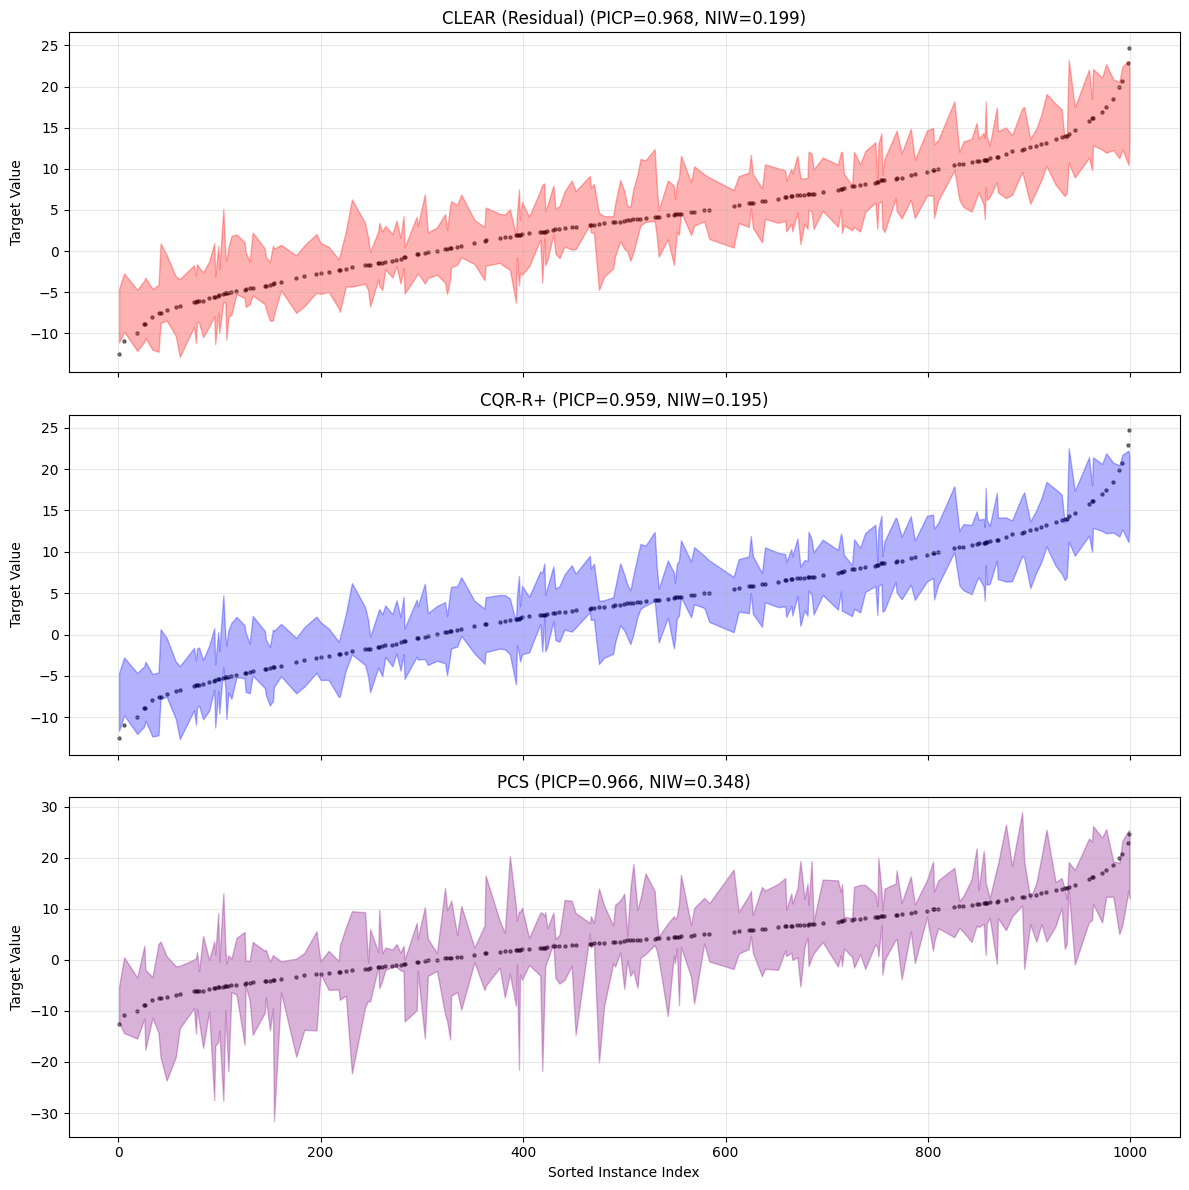

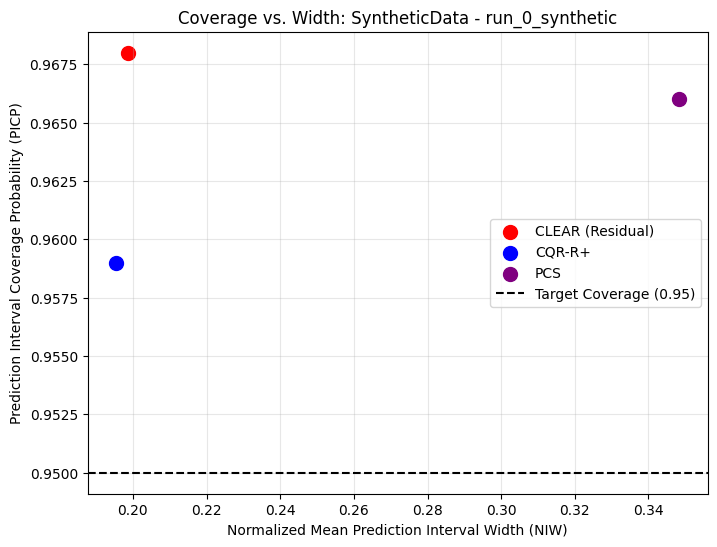

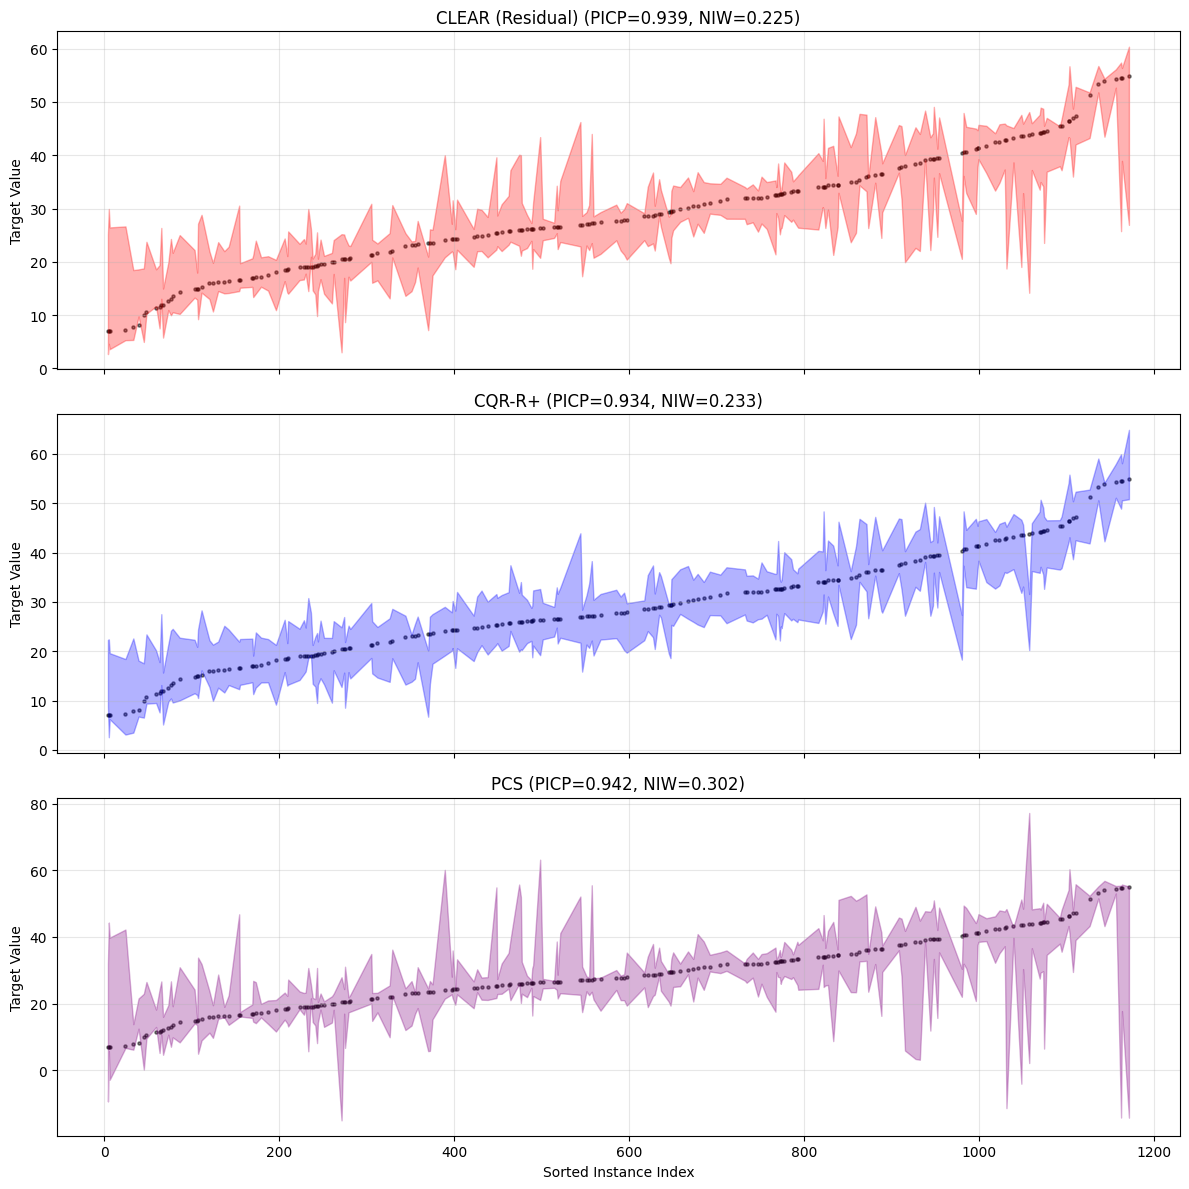

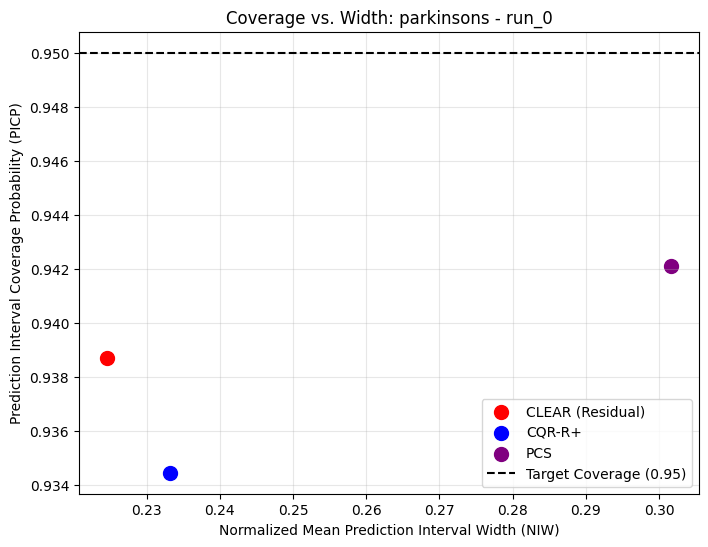

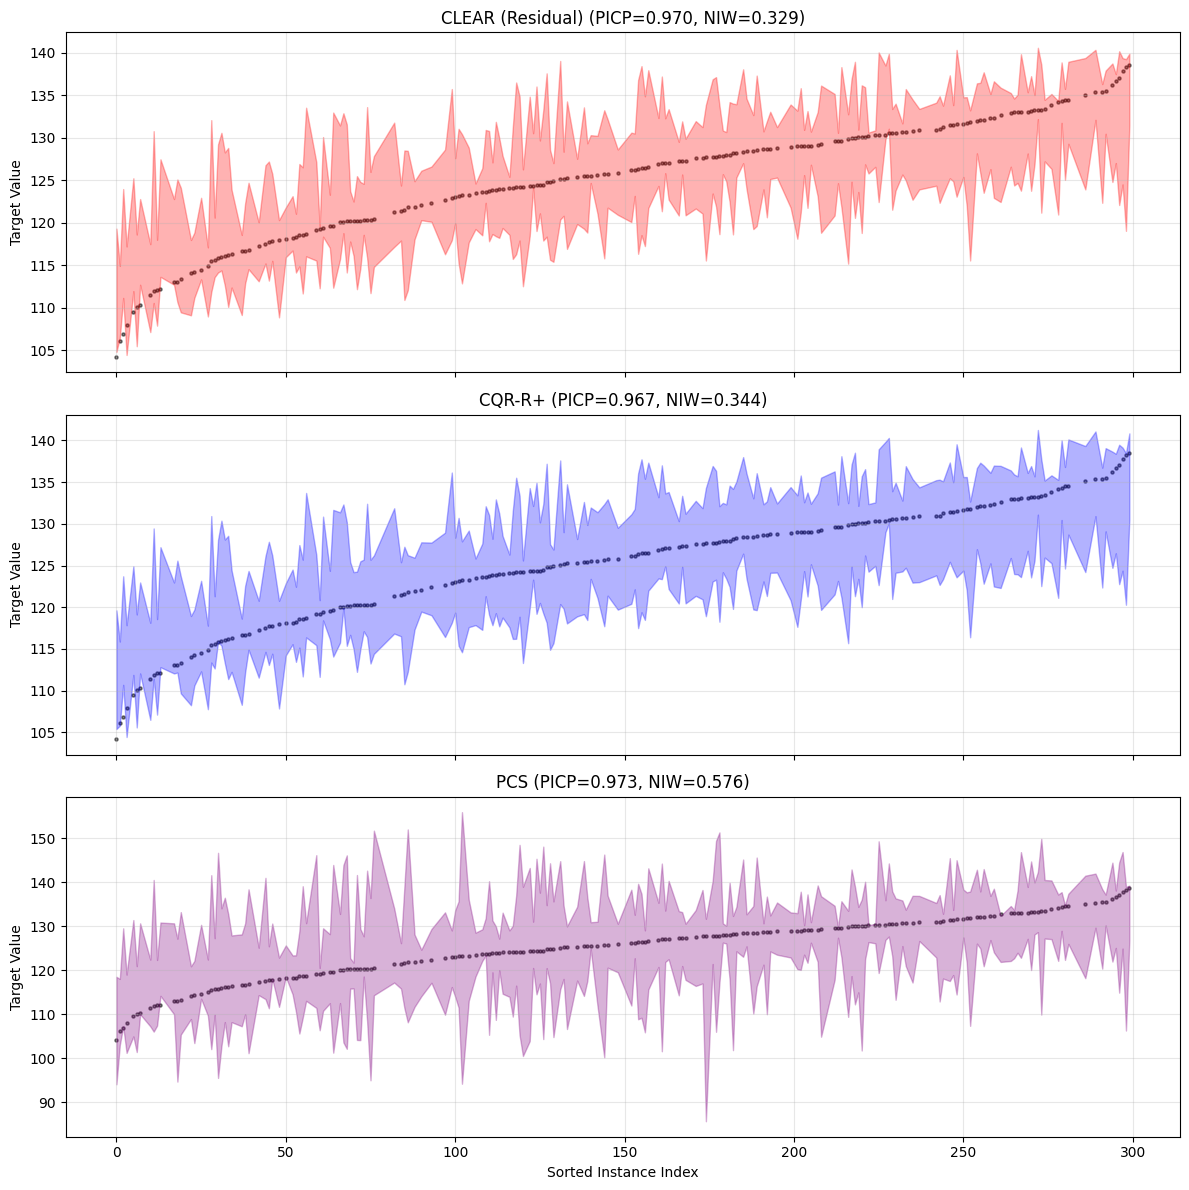

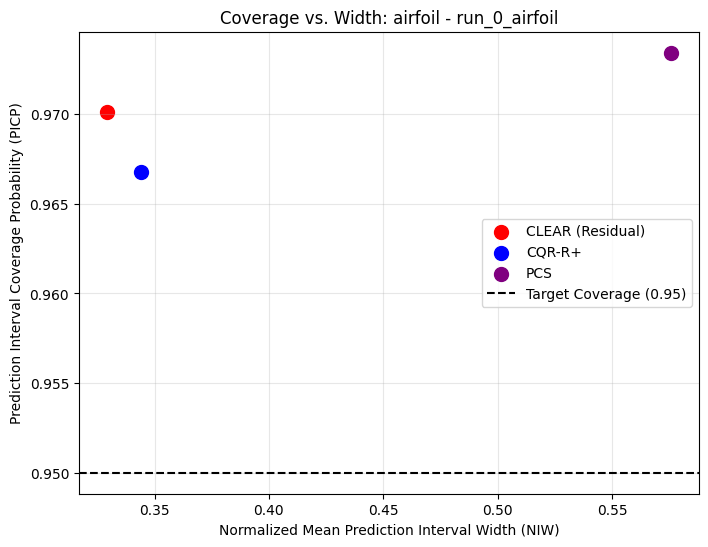

In [32]:
plot_dir = os.path.join("plots", "demo")
os.makedirs(plot_dir, exist_ok=True)

# Case 1: Synthetic Data
print("\nPlotting prediction intervals for Synthetic data case...")
if 'all_intervals_s' in locals() and 'all_eval_medians_s' in locals():
    fig_s = plot_prediction_intervals(
        X_test_s, y_test_s, all_intervals_s,
        dataset_name="SyntheticData",
        run_key="run_0_synthetic", # Placeholder run key
        coverage_target=DESIRED_COVERAGE,
        base_plot_dir=plot_dir,
        display=True # Keep display True to show plots sequentially
    )
    if fig_s:
        print(f"Saved Synthetic data prediction interval plot to directory: {plot_dir}")
else:
    print("Synthetic data results not found for plotting.")

# Case 2: Parkinsons
print("\nPlotting prediction intervals for Parkinsons case...")
if 'all_intervals_p' in locals() and 'all_eval_medians_p' in locals():
    # plot_prediction_intervals expects a dictionary where keys are method names
    # and values are (lower_bounds, upper_bounds, metrics_dict)
    fig_p = plot_prediction_intervals(
        X_test_p, y_test_p, all_intervals_p,
        dataset_name=PARKINSONS_DATASET_NAME,
        run_key=run_key_p if 'run_key_p' in locals() else "run_0_parkinsons",
        coverage_target=DESIRED_COVERAGE,
        base_plot_dir=plot_dir,
        display=True 
    )
    if fig_p:
        print(f"Saved Parkinsons prediction interval plot to directory: {plot_dir}")
else:
    print("Parkinsons results not found for plotting.")

# Case 3: Airfoil
print("\nPlotting prediction intervals for Airfoil case...")
if 'all_intervals_a' in locals() and 'all_eval_medians_a' in locals():
    fig_a = plot_prediction_intervals(
        X_test_a, y_test_a, all_intervals_a,
        dataset_name=AIRFOIL_DATASET_NAME,
        run_key="run_0_airfoil", # Placeholder run key
        coverage_target=DESIRED_COVERAGE,
        base_plot_dir=plot_dir,
        display=True
    )
    if fig_a:
        print(f"Saved Airfoil prediction interval plot to directory: {plot_dir}")
else:
    print("Airfoil results not found for plotting.")

